# Build multiclass classifiers with Amazon SageMaker linear learner to predict Risk Index per Region

In [1]:
import time
st = time.time()

In [2]:
!pip install sagemaker

zsh:1: command not found: pip


### Import the libraries into the notebook

In [3]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import ipaddress
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
import time
import boto3
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

### Update the credentials for S3 Bucket
We will ingest the data files which were pre-processed in the earlier steps using the Data pre-processing Notebook

In [4]:
BUCKET_TYPE="s3"
BUCKET_NAME=""
BUCKET_REGION=""
AWS_ACCESS_KEY_ID=""
AWS_SECRET_ACCESS_KEY=""

### Create an instance with S3 Credentials 

In [5]:
s3 = boto3.resource(
    service_name = BUCKET_TYPE,
    region_name = BUCKET_REGION,
    aws_access_key_id = AWS_ACCESS_KEY_ID,
    aws_secret_access_key = AWS_SECRET_ACCESS_KEY
)

### Read and display the available datasets in S3 Bucket

In [6]:
datasets = []
for obj in s3.Bucket(BUCKET_NAME).objects.all():
    datasets.append(obj.key)
datasets

['15-day-pred.csv',
 'Belgium-country-output.csv',
 'Belgium-ts.csv',
 'Data-region-RI-SM.csv',
 'Risk-Index-Output/',
 'Risk-Index_data/',
 'Risk-Index_data/Data-region-RI-SM-Scoring.csv',
 'Risk-Index_data/Data-region-RI-SM.csv',
 'Risk-Index_data/Data-region-RI.csv',
 'Risk-Index_data/RI_data.csv',
 'Risk-Index_data/test.csv',
 'Risk-Index_data/train.csv',
 'Risk-Index_data/ts-data-region-RI.csv',
 'Risk_Index/Risk_index_training_recoded.csv',
 'flanders-output.csv',
 'my_pred_model_Belgium.h5',
 'my_pred_model_Flanders.h5',
 'pred-data-15.csv',
 'pred-data.csv',
 'pred-models/',
 'raw-data/',
 'raw-data/COVID19BE_CASES_AGESEX.csv',
 'raw-data/COVID19BE_HOSP.csv',
 'test-data.csv',
 'test-y-data.csv',
 'time-series-data/',
 'time-series-data/formatted/',
 'time-series-data/formatted/Belgium-ts.csv',
 'time-series-data/formatted/forecast-data-15.csv',
 'time-series-data/formatted/results/',
 'time-series-data/formatted/ts-Brussels-grouped.csv',
 'time-series-data/formatted/ts-Brussel

### Read the Risk Index per Region data as dataframe and display five records

In [7]:
obj = s3.Bucket(BUCKET_NAME).Object('ts-data-region-RI.csv').get()
data = pd.read_csv(obj['Body'])
data.head()

,DATE,REGION,Total_cases,Risk_Index
0,2020-03-15,Brussels,119,0
1,2020-03-15,Flanders,461,2
2,2020-03-15,Wallonia,383,1
3,2020-03-16,Brussels,238,0
4,2020-03-16,Flanders,794,2


### Identify the Data Types

In [8]:
data.dtypes

DATE           object
REGION         object
Total_cases     int64
Risk_Index      int64
dtype: object

### Drop the Date attribute as we will not be using it

In [9]:
data.drop('DATE', axis=1, inplace=True)
data

,REGION,Total_cases,Risk_Index
0,Brussels,119,0
1,Flanders,461,2
2,Wallonia,383,1
3,Brussels,238,0
4,Flanders,794,2
...,...,...,...
2215,Brussels,677,0
2216,Flanders,7909,2
2217,Wallonia,1371,1
2218,Flanders,295,2


### Encode the Region data into integers

Brussels is encoded as 0 ::: Flanders is encoded as 1 ::: Wallonia is encoded as 2

In [10]:
label_encoder = preprocessing.LabelEncoder()

data['REGION']= label_encoder.fit_transform(data['REGION'])

data

,REGION,Total_cases,Risk_Index
0,0,119,0
1,1,461,2
2,2,383,1
3,0,238,0
4,1,794,2
...,...,...,...
2215,0,677,0
2216,1,7909,2
2217,2,1371,1
2218,1,295,2


### Convert dataframe to numpy array

In [11]:
data = data.to_numpy(dtype ='float32')

### Generate Data features (input) & Data Labels (target)

In [12]:
data_features, data_labels = data[:, :2], data[:, 2]

In [13]:
data_labels

array([0., 2., 1., ..., 1., 2., 0.], dtype=float32)

### Split the data into training & testing data with 80:20 ratio

In [14]:
np.random.seed(0)
train_features, test_features, train_labels, test_labels = train_test_split(
    data_features, data_labels, test_size=0.2)

### Further split the test set into validation and test sets

In [15]:
val_features, test_features, val_labels, test_labels = train_test_split(
    test_features, test_labels, test_size=0.5)

### Check the count of observations in features & labels

In [16]:
len(train_features)
len(train_labels)

1776

### Assign label names and count label frequencies

<AxesSubplot:title={'center':'Label Counts'}>

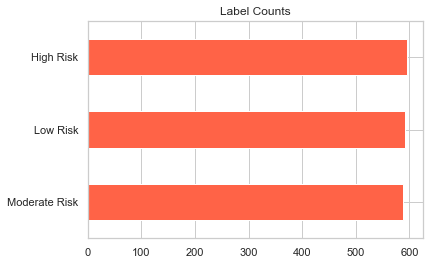

In [17]:
label_map = {0:'Low Risk', 1:'Moderate Risk', 2:'High Risk'}
label_counts = pd.DataFrame(data=train_labels)[0].map(label_map).value_counts(sort=False).sort_index(ascending=False)
label_counts.plot(kind='barh', color='tomato', title='Label Counts')

In [18]:
import sagemaker
session = boto3.session.Session(
    aws_access_key_id = AWS_ACCESS_KEY_ID,
    aws_secret_access_key = AWS_SECRET_ACCESS_KEY,
    region_name = BUCKET_REGION
)
region = session.region_name
sagemaker_session = sagemaker.Session(session)

In [19]:
import os
os.environ['AWS_DEFAULT_REGION'] = BUCKET_REGION
os.environ['AWS_ACCESS_KEY_ID'] = AWS_ACCESS_KEY_ID
os.environ['AWS_SECRET_ACCESS_KEY'] = AWS_SECRET_ACCESS_KEY

## Model Building Process

### Instantiate the LinearLearner estimator object

### Update the SageMaker Full Access role in the below cell

In [20]:
role=''

In [21]:
import sagemaker
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

multiclass_estimator = sagemaker.LinearLearner(role=role,
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               predictor_type='multiclass_classifier',
                                               num_classes=3)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Wrap data in RecordSet objects

In [22]:
train_records = multiclass_estimator.record_set(train_features, train_labels, channel='train')
val_records = multiclass_estimator.record_set(val_features, val_labels, channel='validation')
test_records = multiclass_estimator.record_set(test_features, test_labels, channel='test')

### Start a training job

In [23]:
multiclass_estimator.fit([train_records, val_records, test_records])

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-07-27 08:37:19 Starting - Starting the training job...ProfilerReport-1658911038: InProgress
...
2022-07-27 08:38:22 Starting - Preparing the instances for training......
2022-07-27 08:39:22 Downloading - Downloading input data...
2022-07-27 08:40:03 Training - Downloading the training image...
2022-07-27 08:40:43 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/27/2022 08:40:44 INFO 140094935398208] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': 


2022-07-27 08:41:12 Uploading - Uploading generated training model
2022-07-27 08:41:43 Completed - Training job completed
ProfilerReport-1658911038: NoIssuesFound
Training seconds: 132
Billable seconds: 132


### Deploy a model hosting endpoint

In [24]:
multiclass_predictor = multiclass_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


--

KeyboardInterrupt: 

### Evaluate a model on a test set using the given prediction endpoint. Display classification metrics

In [ ]:
def evaluate_metrics(predictor, test_features, test_labels):
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label['predicted_label'].float32_tensor.values
    test_preds = np.concatenate([np.array([extract_label(x) for x in batch]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    
    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))

### Evaluate metrics of the model trained with default hyperparameters

In [ ]:
evaluate_metrics(multiclass_predictor, test_features, test_labels)

### Instantiate the LinearLearner estimator object

In [ ]:
balanced_multiclass_estimator = sagemaker.LinearLearner(role=role,
                                                        train_instance_count=1,
                                                        train_instance_type='ml.m4.xlarge',
                                                        predictor_type='multiclass_classifier',
                                                        num_classes=7,
                                                        balance_multiclass_weights=True)

### Start a training job

In [ ]:
balanced_multiclass_estimator.fit([train_records, val_records, test_records])

### Deploy a model hosting endpoint

In [ ]:
balanced_multiclass_predictor = balanced_multiclass_estimator.deploy(initial_instance_count=1, 
                                                                     instance_type='ml.m4.xlarge')

### Evaluate metrics of the model trained with balanced class weights

In [ ]:
evaluate_metrics(balanced_multiclass_predictor, test_features, test_labels)

### Print the deployed endpoints

In [ ]:
client = boto3.client('sagemaker')
response = client.list_endpoints(
    StatusEquals = 'InService'
)
print(response)

In [ ]:
#ARN
arn:aws:sagemaker:

In [ ]:
#ARN
arn:aws:sagemaker:

### Delete endpoints

In [ ]:
multiclass_predictor.delete_endpoint()
balanced_multiclass_predictor.delete_endpoint()

### In this Notebook, we have learnt how to predict Risk Index using multiclass classifier SageMaker Models. How to build, run and evaluate them in Watson Studio platform. These models are deployed on SageMaker Platform.

In [ ]:
print("> The Notebook ran in : ", time.time() - st) 